In [1]:
In [1]: %load_ext autoreload

In [2]: %autoreload 2

In [60]:
import preproc_RNN_LSTM
import plot_evaluate_models
import numpy as np

# Import imput data

In [140]:
data = preproc_RNN_LSTM.get_baseline_data("raw_data/preproc_data_rate.csv")


# Set parameters

In [141]:
n_sequences=4000
length=60
prediction_horizon = 31

# Modelling

## set training and test set, define model

In [142]:
X_train, y_train, X_test, y_test = preproc_RNN_LSTM.get_train_test(data,n_sequences,length)

In [143]:
model1 = preproc_RNN_LSTM.model(n_sequences, length-prediction_horizon, 30, prediction_horizon)

In [144]:
model1

## train model

In [145]:
preproc_RNN_LSTM.fit_model(X_train, y_train, model1)

Epoch 1/2000
88/88 [==============================] - 4s 20ms/step - loss: 0.0486 - val_loss: 0.0505
Epoch 2/2000
88/88 [==============================] - 1s 13ms/step - loss: 0.0449 - val_loss: 0.0491
Epoch 3/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0440 - val_loss: 0.0480
Epoch 4/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0434 - val_loss: 0.0474
Epoch 5/2000
88/88 [==============================] - 1s 13ms/step - loss: 0.0425 - val_loss: 0.0462
Epoch 6/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0413 - val_loss: 0.0451
Epoch 7/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0404 - val_loss: 0.0468
Epoch 8/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0402 - val_loss: 0.0849
Epoch 9/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0398 - val_loss: 0.0439
Epoch 10/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0393 - val_lo

88/88 [==============================] - 1s 14ms/step - loss: 0.0279 - val_loss: 0.0333
Epoch 82/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0276 - val_loss: 0.0344
Epoch 83/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0271 - val_loss: 0.0329
Epoch 84/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0268 - val_loss: 0.0355
Epoch 85/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0266 - val_loss: 0.0321
Epoch 86/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0268 - val_loss: 0.0330
Epoch 87/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0267 - val_loss: 0.0323
Epoch 88/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0265 - val_loss: 0.0320
Epoch 89/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0268 - val_loss: 0.0334
Epoch 90/2000
88/88 [==============================] - 1s 14ms/step - loss: 0.0262 - val_loss: 0

# Check outputs

## Check validation set

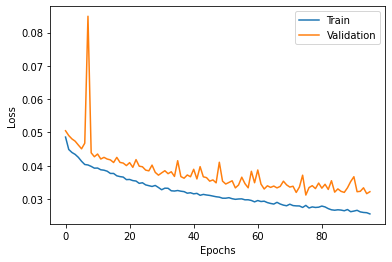

In [146]:
plt.plot(model1.history.history['loss'])
plt.plot(model1.history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'])
plt.show()

## Check predicted vs actual on test set

performances computed on test set:0.05657795071601868


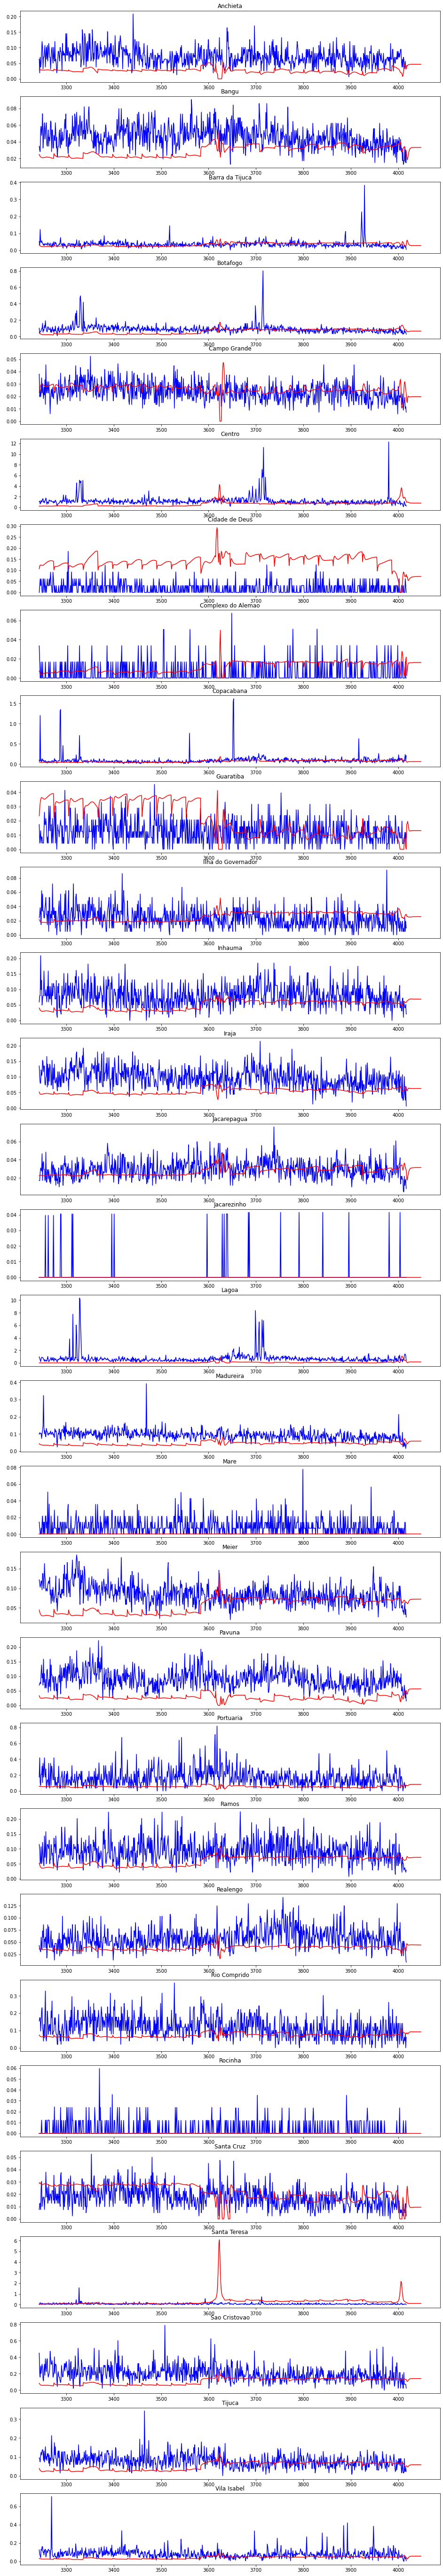

In [147]:
y_pred_df = plot_evaluate_models.compute_plot_pred_multi(data,model1,n_sequences,length)